# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'google_merch_store_raw_merge.csv'

sample_filepath=r'google_merch_store_ga4_merch_flattened_raw_000000000000.csv'



file_tag = "ga4_merch_store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


# data functions

In [3]:
%run "data_functions.py"


data_functions lodaded


# Load

In [4]:
test_data=True
# test_data=False

if test_data==True:
    # Specify the chunk size (e.g., load 1000 lines at a time)
    chunk_size = 50000

    # Initialize an empty list to store the chunks
    chunks = []

    # Load the first chunk (or any number of chunks you want)
    for chunk in pd.read_csv(filepath, chunksize=chunk_size, parse_dates=["event_date"],date_format="%Y-%m-%d"):
        chunks.append(chunk)
        # Break after the first chunk to load only a sample
        break

    # Concatenate the chunks into a single DataFrame (optional)
    data = pd.concat(chunks)

    # data=pd.read_csv(filepath)

    # data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], infer_datetime_format=True)

    # # sort values by session id so that sessions are ordered and not excluded from dataset
    # data = data.sort_values(by=['session_id', 'event_timestamp'], ascending=True)
 
    # # 1% sample
    # data=data.sample(frac=0.01, replace=False)

    

else:
    data=pd.read_csv(filepath)

    data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], infer_datetime_format=True)

    # sort values by session id so that sessions are ordered and not excluded from dataset
    data = data.sort_values(by=['session_id', 'event_timestamp'], ascending=True)
 
    # 10% sample
    data=data.sample(frac=0.1, replace=False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   event_date                       50000 non-null  datetime64[ns]
 1   session_id                       50000 non-null  int64         
 2   user_pseudo_id                   50000 non-null  float64       
 3   event_name                       50000 non-null  object        
 4   event_timestamp                  50000 non-null  int64         
 5   page_location                    50000 non-null  object        
 6   page_title                       49823 non-null  object        
 7   device_category                  50000 non-null  object        
 8   device_mobile_brand_name         50000 non-null  object        
 9   device_mobile_model_name         50000 non-null  object        
 10  device_mobile_marketing_name     50000 non-null  object   

In [5]:
data.shape

(50000, 48)

# class target column creation


we want to classify if that hit is from a returning or new user so we need to group the ga_session_number by 1 or more than 1 session. in this case, new user (ga_session_number = 1) will be 0 and returning user will be more than 1 (ga_session_number > 1)

In [6]:
data['returning_user'] = data['ga_session_number'].apply(lambda x: 0 if x == 1 else 1)


# date column creation

## event_date

In [7]:
# create year, quarter, month, day number of week, weekend/weekday based on event_date column

# Create new columns
data['year'] = data['event_date'].dt.year
data['quarter'] = data['event_date'].dt.quarter
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.weekday  # Monday=0, Sunday=6
data['day_of_year'] = data['event_date'].dt.dayofyear  # Day of the year
data['week_number'] = data['event_date'].dt.isocalendar().week  # ISO week number
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 1 for weekend, 0 for weekday



# event_timestamp

In [8]:
# Convert 'event_timestamp' from microseconds to datetime
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='us')

# Create new columns
data['hour_of_day'] = data['event_timestamp'].dt.hour  # Extract hour (0-23)
data['minute'] = data['event_timestamp'].dt.minute  # Extract minute
data['second'] = data['event_timestamp'].dt.second  # Extract second
data['hour_minute_fraction'] = data['hour_of_day'] + data['minute'] / 60  # Hour + fraction of minute

# Categorize the time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time_of_day'] = data['hour_of_day'].apply(categorize_time_of_day)

# column drop

### low value or high null count columns

In [9]:
data=data.drop(['debug_mode','device_is_limited_ad_tracking','device_mobile_marketing_name','geo_metro','traffic_source_name','page_referrer','entrances'],axis=1)

### ecommerce specific columns

In [10]:
data=data.drop([
 'ecommerce_total_item_quantity', 
 'ecommerce_purchase_revenue',            
 'ecommerce_shipping_value',              
 'ecommerce_tax_value',                   
 'ecommerce_unique_items',               
 'ecommerce_transaction_id',              
 'item_id',                               
 'item_name',                             
 'item_brand',                            
 'item_variant',                          
 'item_category',                         
 'price',                                 
 'quantity',                              
 'item_revenue',                          
 'item_list_index',                       
 'promotion_name'],axis=1)

In [11]:
summary5 = data.describe(include="all")

summary5

,event_date,session_id,user_pseudo_id,event_name,event_timestamp,page_location,page_title,device_category,device_mobile_brand_name,device_mobile_model_name,...,day,day_of_week,day_of_year,week_number,is_weekend,hour_of_day,minute,second,hour_minute_fraction,time_of_day
count,50000,5.000000e+04,5.000000e+04,50000,50000,50000,49823,50000,50000,50000,...,50000.00000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000
unique,NaN,NaN,NaN,17,NaN,609,411,3,8,10,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,NaN,view_item,NaN,https://shop.googlemerchandisestore.com/,Home,desktop,Apple,Chrome,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,Night
freq,NaN,NaN,NaN,15791,NaN,5094,8713,28892,21209,13879,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,16656
mean,2020-12-16 14:20:36.096000256,4.978973e+09,2.478379e+08,NaN,2020-12-17 02:21:09.105818112,NaN,NaN,NaN,NaN,NaN,...,16.01842,2.962900,227.882320,33.832,0.272160,11.509340,29.492640,29.32508,12.000884,NaN
min,2020-11-01 00:00:00,6.412000e+03,1.000300e+06,NaN,2020-11-01 00:02:11.014828,NaN,NaN,NaN,NaN,NaN,...,1.00000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,2020-11-23 00:00:00,2.508468e+09,5.706021e+06,NaN,2020-11-23 16:20:17.499265536,NaN,NaN,NaN,NaN,NaN,...,9.00000,1.000000,23.000000,3.0,0.000000,5.000000,14.000000,14.00000,5.966667,NaN
50%,2020-12-15 00:00:00,4.968109e+09,2.033435e+07,NaN,2020-12-15 20:34:26.141175040,NaN,NaN,NaN,NaN,NaN,...,16.00000,3.000000,320.000000,47.0,0.000000,12.000000,29.000000,29.00000,12.000000,NaN
75%,2021-01-10 00:00:00,7.461751e+09,5.997908e+07,NaN,2021-01-10 00:28:35.167044352,NaN,NaN,NaN,NaN,NaN,...,23.00000,5.000000,345.000000,50.0,1.000000,18.000000,45.000000,44.00000,18.000000,NaN
max,2021-01-31 00:00:00,9.999205e+09,9.986757e+09,NaN,2021-01-31 23:54:27.503961,NaN,NaN,NaN,NaN,NaN,...,31.00000,6.000000,366.000000,53.0,1.000000,23.000000,59.000000,59.00000,23.983333,NaN


# row drop (from values)

## specific event_names



In [12]:
data['event_name'].value_counts()

event_name
view_item              15791
page_view              10380
user_engagement         7970
scroll                  3645
add_to_cart             3291
session_start           2777
first_visit             1953
select_item             1617
view_promotion          1356
begin_checkout           583
view_search_results      192
add_shipping_info        145
purchase                 123
add_payment_info          99
select_promotion          65
click                     10
view_item_list             3
Name: count, dtype: int64

### event_name insights
We want to classify a user by its interactions with the website so we want to exclude some actions that may also be biased by incorrect ga4 tracking namely:
- session_start
- first_visit
- click (low event count)
- view_item_list (may not be triggered by user interaction)

In [13]:
# List of values to drop
events_to_drop = ['session_start', 'first_visit','click','view_item_list']

# drop events from list
data = data[~data['event_name'].isin(events_to_drop)]


data['event_name'].value_counts()

event_name
view_item              15791
page_view              10380
user_engagement         7970
scroll                  3645
add_to_cart             3291
select_item             1617
view_promotion          1356
begin_checkout           583
view_search_results      192
add_shipping_info        145
purchase                 123
add_payment_info          99
select_promotion          65
Name: count, dtype: int64

# replace (not set) and Other with null

we will handle these later but these are actually null values

In [14]:
data.replace('(not set)', np.nan, inplace=True)

data.replace('<Other>', np.nan, inplace=True)


# replace null with 0 columns

In [15]:
data['engagement_time_msec'] = data['engagement_time_msec'].fillna(0)


# geo columns

## move subcontinent

In [16]:
# Move 'geo_sub_continent' from index 16 after continent

# Pop 'geo_sub_continent' column
geo_sub_continent = data.pop('geo_sub_continent')  # Remove the column

# Insert 'geo_sub_continent' at index 16
data.insert(16, 'geo_sub_continent', geo_sub_continent)


# Display the reordered DataFrame
print("\nReordered DataFrame:")
data.info()


Reordered DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 45257 entries, 0 to 49999
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   event_date                       45257 non-null  datetime64[ns]
 1   session_id                       45257 non-null  int64         
 2   user_pseudo_id                   45257 non-null  float64       
 3   event_name                       45257 non-null  object        
 4   event_timestamp                  45257 non-null  datetime64[ns]
 5   page_location                    45257 non-null  object        
 6   page_title                       45132 non-null  object        
 7   device_category                  45257 non-null  object        
 8   device_mobile_brand_name         41745 non-null  object        
 9   device_mobile_model_name         35935 non-null  object        
 10  device_operating_system          44068 no

## geo_continent

In [17]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'geo_continent', ['device_category'])

data['geo_continent'].value_counts()

geo_continent
Americas    25780
Asia        10453
Europe       8197
Africa        416
Oceania       411
Name: count, dtype: int64

## geo_sub_continent

In [18]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'geo_sub_continent', ['device_category','geo_continent'])

data['geo_sub_continent'].value_counts()

geo_sub_continent
Northern America    24014
Southern Asia        4414
Eastern Asia         3021
Western Europe       2686
Northern Europe      2245
Southern Europe      2123
Southeast Asia       1826
South America        1180
Western Asia         1155
Eastern Europe       1143
Central America       475
Australasia           411
Northern Africa       203
Caribbean             111
Western Africa         76
Southern Africa        61
Eastern Africa         60
Central Asia           37
Middle Africa          16
Name: count, dtype: int64

## geo_country

In [19]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'geo_country', ['device_category','geo_continent'])

data['geo_country'].value_counts()

geo_country
United States     20510
India              4116
Canada             3551
United Kingdom     1381
Spain               958
                  ...  
Honduras              6
Oman                  5
Kosovo                3
Ghana                 3
Malta                 3
Name: count, Length: 108, dtype: int64

## geo_region and geo_city

In [20]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'geo_region', ['device_category','geo_continent','geo_country'])

data['geo_region'].value_counts()

geo_region
California                4686
Texas                     1609
New York                  1528
Ontario                   1495
England                   1238
                          ... 
Guayas                       2
Gangwon-do                   2
Alexandria Governorate       2
Bratislava Region            2
Kharkiv Oblast               1
Name: count, Length: 365, dtype: int64

In [21]:
null_countries_df=data.groupby(['geo_country']).agg(
    null_count=('geo_region', lambda x: x.isna().sum())
).sort_values('null_count',ascending=False).reset_index()


countries_with_nulls = null_countries_df[null_countries_df['null_count'] > 0]['geo_country'].tolist()

print(countries_with_nulls)
# will retrieve the most populated cities of these countries to use as fill method

['Singapore', 'Hong Kong', 'Peru', 'Dominican Republic', 'Palestine', 'Iraq', 'Serbia', 'Uruguay', 'North Macedonia', 'Armenia', 'Cyprus', 'Bahrain', 'Panama', 'Azerbaijan', 'Venezuela', 'Albania', 'Luxembourg', 'Jamaica', 'Macao', 'Paraguay', 'Trinidad & Tobago', 'Bolivia', 'Honduras', 'Morocco', 'Kosovo', 'Slovakia', 'Malta', 'New Zealand', 'Bulgaria', 'Argentina']


In [22]:
most_populated_cities = {
    'Singapore': 'Singapore',
    'Hong Kong': 'Hong Kong',
    'Peru': 'Lima',
    'Dominican Republic': 'Santo Domingo',
    'Palestine': 'Gaza',
    'Iraq': 'Baghdad',
    'Serbia': 'Belgrade',
    'Uruguay': 'Montevideo',
    'North Macedonia': 'Skopje',
    'Cyprus': 'Nicosia',
    'Bahrain': 'Manama',
    'Armenia': 'Yerevan',
    'Panama': 'Panama City',
    'Azerbaijan': 'Baku',
    'Venezuela': 'Caracas',
    'Albania': 'Tirana',
    'Luxembourg': 'Luxembourg',
    'Jamaica': 'Kingston',
    'Macao': 'Macau',
    'Bolivia': 'Santa Cruz de la Sierra',
    'Trinidad & Tobago': 'Chaguanas',
    'Honduras': 'Tegucigalpa',
    'Paraguay': 'Asuncion',
    'Morocco': 'Casablanca',
    'Kosovo': 'Pristina',
    'Slovakia': 'Bratislava',
    'Malta': 'Birkirkara',
    'New Zealand': 'Auckland',
    'Bulgaria': 'Sofia',
    'Bangladesh': 'Dhaka',
    'Nigeria': 'Lagos'
}



data['geo_region'] = data['geo_region'].fillna(data['geo_country'].map(most_populated_cities))
data['geo_city'] = data['geo_city'].fillna(data['geo_country'].map(most_populated_cities))

In [23]:
null_regions_df=data.groupby(['geo_region']).agg(
    null_count=('geo_region', lambda x: x.isna().sum())
).sort_values('null_count',ascending=False).reset_index()

null_regions_df


,geo_region,null_count
0,Abruzzo,0
1,Prague,0
2,Pomeranian Voivodeship,0
3,Podkarpackie Voivodeship,0
4,Piedmont,0
...,...,...
388,Greater Accra Region,0
389,Grand Est,0
390,Giza Governorate,0
391,Georgia,0


In [24]:
null_region_cities_df=data.groupby(['geo_region']).agg(
    null_count=('geo_city', lambda x: x.isna().sum())
).sort_values('null_count',ascending=False).reset_index()


region_cities_with_nulls = null_region_cities_df[null_region_cities_df['null_count'] > 0]['geo_region'].tolist()


region_cities_with_nulls

['California',
 'England',
 'Florida',
 'Texas',
 'New York',
 'Pennsylvania',
 'New Jersey',
 'Michigan',
 'Taipei City',
 'Ontario',
 'Georgia',
 'Illinois',
 'Ohio',
 'Massachusetts',
 'Virginia',
 'Tokyo',
 'Maryland',
 'Quebec',
 'North Carolina',
 'Ile-de-France',
 'Connecticut',
 'Missouri',
 'Wisconsin',
 'Colorado',
 'Maharashtra',
 'Utah',
 'Alberta',
 'Washington',
 'Catalonia',
 'Indiana',
 'British Columbia',
 'South Carolina',
 'State of Sao Paulo',
 'New Taipei City',
 'Minnesota',
 'North Rhine-Westphalia',
 'Moscow',
 'Tennessee',
 'Flanders',
 'Louisiana',
 'Lombardy',
 'Oklahoma',
 'Alabama',
 'Oregon',
 'Bavaria',
 'Kentucky',
 'Iowa',
 'Zurich',
 'Baden-Wurttemberg',
 'Istanbul',
 'Mississippi',
 'Zhejiang',
 'Mexico City',
 'Kansas',
 'Cairo Governorate',
 'Arizona',
 'Taiwan Province',
 'Ho Chi Minh City',
 'North Holland',
 'Stockholm County',
 'West Bengal',
 'Bucharest',
 'Auvergne-Rhone-Alpes',
 'Arkansas',
 'Lisbon',
 'Metro Manila',
 'Tamil Nadu',
 'County 

In [25]:
most_populated_cities_by_region = {
    'Taipei City': 'Taipei',
    'New Taipei City': 'New Taipei',
    'Taichung City': 'Taichung',
    'Kaohsiung City': 'Kaohsiung',
    'West Virginia': 'Charleston',
    'Delaware': 'Wilmington',
    'State of Mexico': 'Ecatepec',
    'Buenos Aires Province': 'La Plata',
    'Montana': 'Billings',
    'Wallonia': 'Liège',
    'Alaska': 'Anchorage',
    'Grand Est': 'Strasbourg',
    'Henan': 'Zhengzhou',
    'Hawalli Governorate': 'Hawalli',
    'Gelderland': 'Arnhem',
    'Algiers Province': 'Algiers',
    'North Dakota': 'Fargo',
    'Vermont': 'Burlington',
    'Idaho': 'Boise',
    'Canary Islands': 'Las Palmas',
    'Castile-La Mancha': 'Toledo',
    'Lublin Voivodeship': 'Lublin',
    'Calabarzon': 'Cavite City',
    'Saxony': 'Dresden',
    'Castile and Leon': 'Valladolid',
    'State of Bahia': 'Salvador',
    'Limburg': 'Hasselt',
    'Tainan City': 'Tainan',
    'Moscow Oblast': 'Khimki',
    'Chiba': 'Chiba',
    'Prince Edward Island': 'Charlottetown',
    'Overijssel': 'Zwolle',
    'Haifa District': 'Haifa',
    'Liguria': 'Genoa',
    'Northern Ireland': 'Belfast',
    'Rhineland-Palatinate': 'Mainz',
    'Sverdlovsk Oblast': 'Yekaterinburg',
    'Region of Southern Denmark': 'Odense',
    'Decentralized Administration of Peloponnese, Western Greece and the Ionian': 'Patras',
    'Amman Governorate': 'Amman',
    'Silesian Voivodeship': 'Katowice',
    'Asturias': 'Oviedo',
    'Galicia': 'Santiago de Compostela',
    'Hokkaido': 'Sapporo',
    'Quintana Roo': 'Cancún',
    'Centre-Val de Loire': 'Orléans',
    'Tamaulipas': 'Reynosa',
    'State of Santa Catarina': 'Florianópolis',
    'Saitama': 'Saitama',
    'Sicily': 'Palermo',
    'Gyeongsangnam-do': 'Changwon',
    'St. Gallen': 'St. Gallen',
    'Drenthe': 'Assen',
    'State of Ceara': 'Fortaleza',
    'Marche': 'Ancona',
    'West Pomeranian Voivodeship': 'Szczecin',
    'Friuli-Venezia Giulia': 'Trieste',
    'Decentralized Administration of Attica': 'Athens',
    'Viken': 'Drammen',
    'Lower Austria': 'St. Pölten',
    'State of Pernambuco': 'Recife',
    'Veracruz': 'Veracruz',
    'Flanders': 'Antwerp',
    'Kuyavian-Pomeranian Voivodeship': 'Bydgoszcz',
    'Krasnodar Krai': 'Krasnodar',
    'Central Bohemian Region': 'Prague',
    'State of Espirito Santo': 'Vitória',
    'Abruzzo': 'Pescara',
    'Region Zealand': 'Roskilde',
    'Maryland': 'Baltimore',
    'South District': 'Ashdod',
    'Normandy': 'Rouen',
    'Iowa': 'Des Moines',
    'Jerusalem District': 'Jerusalem',
    'Wisconsin': 'Milwaukee',
    'Gyeongsangbuk-do': 'Gyeongju',
    'Puebla': 'Puebla',
    'Friesland': 'Leeuwarden',
    'Bourgogne-Franche-Comte': 'Dijon',
    'Chungcheongbuk-do': 'Cheongju',
    'Sonora': 'Hermosillo',
    'Penang': 'George Town',
    'Federation of Bosnia and Herzegovina': 'Sarajevo',
    'Trentino-South Tyrol': 'Bolzano',
    'Cordoba': 'Córdoba',
    'Hyogo': 'Kobe',
    'Brandenburg': 'Potsdam',
    'Baden-Wurttemberg': 'Stuttgart',
    'Setubal': 'Setúbal',
    'Guanajuato': 'Guanajuato',
    'Kocaeli': 'Izmit',
    'Groningen': 'Groningen',
    'Muscat Governorate': 'Muscat',
    'Giza Governorate': 'Giza',
    'Arkansas': 'Little Rock',
    'Community of Madrid': 'Madrid',
    'Skane County': 'Malmö',
    'South Moravian Region': 'Brno',
    'Podkarpackie Voivodeship': 'Rzeszów',
    'Minnesota': 'Minneapolis',
    'Utrecht': 'Utrecht',
    'North Rhine-Westphalia': 'Cologne',
    'Indiana': 'Indianapolis',
    'Louisiana': 'New Orleans',
    'Odisha': 'Bhubaneswar',
    'Newfoundland and Labrador': 'St. John\'s',
    'Canton of Bern': 'Bern',
    'Bihar': 'Patna',
    'Utah': 'Salt Lake City',
    'Lower Saxony': 'Hanover',
    'Guayas': 'Guayaquil',
    'Gangwon-do': 'Gangneung',
    'Brittany': 'Rennes',
    'Mississippi': 'Jackson',
    'Pays de la Loire': 'Nantes',
    'Nuevo Leon': 'Monterrey',
    'New Hampshire': 'Concord',
    'South Dakota': 'Sioux Falls',
    'Chhattisgarh': 'Raipur',
    'Uttarakhand': 'Dehradun'
}

data['geo_city'] = data['geo_city'].fillna(data['geo_region'].map(most_populated_cities_by_region))


In [26]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'geo_city', ['device_category','geo_continent','geo_country','geo_region'])


# device columns

- for many cases we assumed devices, brands and os versions of 2021 as fill method
- since device market share may change by region or country we also used these to consider for mode null fill

## device mobile brand

In [27]:

# Fill 'device_mobile_brand_name' with 'PC' where the conditions are met
data.loc[(data['device_operating_system'] == 'Windows') & (data['device_category'] == 'desktop'), 'device_mobile_brand_name'] = 'PC'
data.loc[(data['device_operating_system'] == 'Web') & (data['device_category'] == 'desktop') & ((data['device_mobile_model_name'].isin(['Chrome','Edge','Firefox']))), 'device_mobile_brand_name'] = 'PC'
data.loc[(data['device_mobile_brand_name'] == 'Microsoft') & (data['device_category'] == 'desktop'), 'device_mobile_brand_name'] = 'PC'



data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_mobile_brand_name', ['device_category','device_operating_system','geo_country'])

data['device_mobile_brand_name'].value_counts()

device_mobile_brand_name
Apple        20895
PC           14490
Samsung       4526
Google        3550
Xiaomi        1069
Huawei         625
Mozilla         35
Microsoft       13
Name: count, dtype: int64

## device_mobile_model_name 

In [28]:


data.loc[(data['device_mobile_brand_name'] == 'Samsung'), 'device_mobile_model_name'] = 'Galaxy S21'

data.loc[(data['device_mobile_brand_name'] == 'Xiaomi'), 'device_mobile_model_name'] = 'Mi 11'

data.loc[(data['device_mobile_brand_name'] == 'Huawei'), 'device_mobile_model_name'] = 'P50'

data.loc[(data['device_mobile_brand_name'] == 'Apple')& (data['device_category'] == 'desktop'), 'device_mobile_model_name'] = 'Macintosh'

data.loc[(data['device_mobile_brand_name'] == 'PC')& (data['device_mobile_model_name'] == 'Chrome'), 'device_mobile_model_name'] = 'PC'



data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_mobile_model_name', ['device_category','device_mobile_brand_name','device_operating_system','geo_country'])


data['device_mobile_model_name'].value_counts()

device_mobile_model_name
PC            12993
iPhone        11238
Macintosh      8979
Galaxy S21     4526
ChromeBook     2519
Mi 11          1069
Edge            938
iPad            674
P50             625
Firefox         591
Pixel 4 XL      417
Pixel 3         324
Chrome          153
Safari            3
Name: count, dtype: int64

## device_operating_system

In [29]:

# Chrome OS - ensure 'desktop' is correctly spelled
data.loc[(data['device_mobile_model_name'] == 'ChromeBook') & (data['device_category'] == 'desktop'), 'device_operating_system'] = 'ChromeOS'

# iOS - for iPhone and iPad
data.loc[data['device_mobile_model_name'].isin(['iPhone', 'iPad']) | (data['device_mobile_brand_name'] == 'Apple') | ((data['device_mobile_model_name'] == 'Apple') & (data['device_category'].isin(['mobile','tablet']))), 'device_operating_system'] = 'iOS'

# Android - for specified brands
android_brands = ['Xiaomi', 'Huawei', 'Samsung']
data.loc[data['device_mobile_brand_name'].isin(android_brands), 'device_operating_system'] = 'Android'
data.loc[(data['device_mobile_brand_name'] == 'Google') & (data['device_category'].isin(['mobile','tablet'])), 'device_operating_system'] = 'Android'

# macOS
data.loc[(data['device_mobile_brand_name'] == 'Apple') & (data['device_category'] == 'desktop'), 'device_operating_system'] = 'MacOS'

# Windows
data.loc[(data['device_operating_system'] == 'Web') & (data['device_category'] == 'desktop') & ((data['device_mobile_brand_name'] == 'PC')), 'device_operating_system'] = 'Windows'
data.loc[(data['device_operating_system'] == 'Web') & (data['device_category'] == 'desktop') & ((data['device_mobile_brand_name'] == 'Mozilla')), 'device_operating_system'] = 'Windows'
data.loc[(data['device_category'] == 'desktop') & ((data['device_mobile_brand_name'] == 'Microsoft')), 'device_operating_system'] = 'Windows'


data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_operating_system', ['device_category','device_operating_system','geo_country'])


data.groupby(['device_category','device_operating_system', 'device_mobile_brand_name']).agg(
    unique_event_count=('event_timestamp', 'nunique')
).sort_values('unique_event_count',ascending=False).reset_index()


,device_category,device_operating_system,device_mobile_brand_name,unique_event_count
0,desktop,Windows,PC,14070
1,mobile,iOS,Apple,10940
2,desktop,MacOS,Apple,8728
3,mobile,Android,Samsung,4176
4,desktop,ChromeOS,Google,2464
5,mobile,Android,Xiaomi,1033
6,mobile,Android,Google,861
7,tablet,iOS,Apple,656
8,mobile,Android,Huawei,582
9,tablet,Android,Samsung,249


## device_operating_system_version

In [30]:
# replace all string characters and keep float values
data['device_operating_system_version'] = data['device_operating_system_version'].str.extract(r'(\d+\.\d+|\d+)')


In [31]:
# for chrome os consider same browser version
# https://chromereleases.googleblog.com/2021/
data.loc[(data['device_operating_system'] == 'ChromeOS') & (data['device_operating_system_version'].isnull()), 'device_operating_system_version'] = data['device_web_info_browser_version']


data['device_operating_system_version'].value_counts()


device_operating_system_version
10       16436
10.15     6317
14.3      2043
14.2      2026
86.0      1224
87.0      1010
9          657
11.1       562
7          415
Name: count, dtype: int64

In [32]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_operating_system_version', ['device_category','device_operating_system','geo_country'])

data['device_operating_system_version'].value_counts()

device_operating_system_version
10       21429
10.15     8391
14.2      6839
14.3      4018
86.0      1425
87.0      1092
9          662
11.1       566
7          416
Name: count, dtype: int64

## device_language

In [33]:
data.groupby(['geo_continent','geo_country','device_language']).agg(
    unique_event_count=('event_timestamp', 'nunique')
).sort_values('unique_event_count',ascending=False).reset_index()

,geo_continent,geo_country,device_language,unique_event_count
0,Americas,United States,en-us,7355
1,Asia,India,en-us,1574
2,Americas,Canada,en-us,1400
3,Americas,United States,en-gb,1186
4,Americas,United States,en,556
...,...,...,...,...
550,Asia,Iraq,en-ca,1
551,Asia,Iraq,en-gb,1
552,Asia,Iraq,zh,1
553,Asia,Thailand,ko,1


In [34]:
data.groupby(['geo_continent','geo_country']).agg(
    null_device_language_count=('device_language', lambda x: x.isna().sum())
).sort_values('null_device_language_count',ascending=False).reset_index()

,geo_continent,geo_country,null_device_language_count
0,Americas,United States,9288
1,Asia,India,1772
2,Americas,Canada,1546
3,Europe,United Kingdom,583
4,Europe,Spain,427
...,...,...,...
103,Europe,Malta,1
104,Americas,Uruguay,1
105,Americas,Trinidad & Tobago,1
106,Americas,Paraguay,0


In [35]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_language', ['geo_country'])


data['device_language'].value_counts()

device_language
en-us    37337
en-gb     2610
zh        1305
en        1181
en-ca      942
fr         678
es-es      620
de         316
ko         268
Name: count, dtype: int64

## device_web_info_browser

In [36]:
data.loc[(data['device_web_info_browser'] == 'Android Webview'), 'device_web_info_browser'] = "Chrome"


data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_web_info_browser', ['device_category','device_operating_system','geo_country'])

data['device_web_info_browser'].value_counts()

device_web_info_browser
Chrome     32422
Safari     11040
Edge         959
Firefox      814
Name: count, dtype: int64

## device_web_info_browser_version

In [37]:
data = fill_nulls_based_on_top_value_multiple_columns(data, 'device_web_info_browser_version', ['device_category','device_web_info_browser','geo_country'])

data['device_web_info_browser_version'].value_counts()

device_web_info_browser_version
87.0    23685
86.0     9634
14.0     8571
604      1182
13.1     1059
84.0      390
83.0      243
13.0      188
82.0      170
87          3
Name: count, dtype: int64

# Traffic Columns

## session counts

In [38]:
data.groupby(['traffic_source_medium','traffic_source_source']).agg(
    unique_session_count=('session_id', 'nunique')
).sort_values('unique_session_count',ascending=False).reset_index()

,traffic_source_medium,traffic_source_source,unique_session_count
0,organic,google,8572
1,(none),(direct),6523
2,referral,shop.googlemerchandisestore.com,2459
3,(data deleted),(data deleted),2177
4,cpc,google,1139


## null counts

In [39]:
data.groupby(['traffic_source_medium']).agg(
    null_count=('traffic_source_source', lambda x: x.isna().sum())
).sort_values('null_count',ascending=False).reset_index()

,traffic_source_medium,null_count
0,referral,4413
1,organic,1120
2,(data deleted),60
3,(none),0
4,cpc,0


In [40]:
data.groupby(['traffic_source_source']).agg(
    null_count=('traffic_source_medium', lambda x: x.isna().sum())
).sort_values('null_count',ascending=False).reset_index()

# no null count on

,traffic_source_source,null_count
0,(data deleted),0
1,(direct),0
2,google,0
3,shop.googlemerchandisestore.com,0


## remove parenthesis ()

In [41]:
data['traffic_source_source'] = data['traffic_source_source'].str.replace(r'\(|\)', '', regex=True).str.strip()
data['traffic_source_medium'] = data['traffic_source_medium'].str.replace(r'\(|\)', '', regex=True).str.strip()


data.groupby(['traffic_source_medium','traffic_source_source']).agg(
    unique_session_count=('session_id', 'nunique')
).sort_values('unique_session_count',ascending=False).reset_index()

,traffic_source_medium,traffic_source_source,unique_session_count
0,organic,google,8572
1,none,direct,6523
2,referral,shop.googlemerchandisestore.com,2459
3,data deleted,data deleted,2177
4,cpc,google,1139


## persist source and medium by session_id first

Since there may be null values inside the session we want to ensure that the value remains the same across the session

In [42]:
# Step 1: Fill null values with the last valid observation for the relevant session
data['traffic_source_source'] = data.groupby('session_id')['traffic_source_source'].fillna(method='ffill')
data['traffic_source_medium'] = data.groupby('session_id')['traffic_source_medium'].fillna(method='ffill')

# # Step 2: Only keep the values for rows where entrances = 1
# data.loc[data['entrances'] != 1, ['traffic_source_source', 'traffic_source_medium']] = None


data.groupby(['traffic_source_medium']).agg(
    null_count=('traffic_source_source', lambda x: x.isna().sum())
).sort_values('null_count',ascending=False).reset_index()

,traffic_source_medium,null_count
0,referral,4409
1,organic,1120
2,data deleted,60
3,cpc,0
4,none,0


## Replace values

- bad referral naming from shop.googlemerchandisestore.com means badly tracked and we should consider direct traffic instead
- medium =none is referring to direct traffic and we will use the same name to not confuse with null values
- data deleted is most likely paid campaign by google to avoid confidential data exposure so we will replace with cpc / google as well


In [43]:

# data.loc[(data['traffic_source_source'] == 'shop.googlemerchandisestore.com') & (data['traffic_source_medium'] == 'referral'), 'traffic_source_source'] = 'direct'
# data.loc[(data['traffic_source_source'] == 'shop.googlemerchandisestore.com') & (data['traffic_source_medium'] == 'referral'), 'traffic_source_medium'] = 'direct'
# source is merchandisestore.com then direct (bad parameter)
data.loc[(data['traffic_source_source'] == 'shop.googlemerchandisestore.com') & (data['traffic_source_medium'] == 'referral'), ['traffic_source_medium', 'traffic_source_source']] = ['direct','direct']


# referral traffic
data.loc[(data['traffic_source_medium'] == 'referral'), ['traffic_source_medium', 'traffic_source_source']] = ['referral','referral_link']

# google organic
data.loc[(data['traffic_source_source'].isnull()) & (data['traffic_source_medium']== 'organic'),  ['traffic_source_medium', 'traffic_source_source']] = ['organic','google']


# when we have direct traffic it is direct traffic
data.loc[(data['traffic_source_source'] == 'direct'), 'traffic_source_medium'] = 'direct'

# data deleted is paid campaign cpc by google
# data.loc[(data['traffic_source_source'] == 'data deleted') | (data['traffic_source_medium'] == 'data deleted'), 'traffic_source_medium'] = 'cpc'
# data.loc[(data['traffic_source_source'] == 'data deleted') | (data['traffic_source_medium'] == 'data deleted'), 'traffic_source_source'] = 'google'
data.loc[(data['traffic_source_source'] == 'data deleted') | (data['traffic_source_medium'] == 'data deleted'), ['traffic_source_medium', 'traffic_source_source']] = ['cpc', 'google']


# full null values are direct
data.loc[(data['traffic_source_source'].isnull()) & (data['traffic_source_medium'].isnull()),  ['traffic_source_medium', 'traffic_source_source']] = ['direct','direct']
# data.loc[(data['traffic_source_source'].isnull()) & (data['traffic_source_medium'].isnull()), 'traffic_source_medium'] = 'direct'



# data = fill_nulls_based_on_top_value_multiple_columns(data, 'traffic_source_source', ['device_category','geo_country'])
# data = fill_nulls_based_on_top_value_multiple_columns(data, 'traffic_source_medium', ['device_category','geo_country','traffic_source_source','traffic_source_medium'])


data.groupby(['traffic_source_source','traffic_source_medium']).agg(
    unique_session_count=('session_id', 'nunique')
).sort_values('unique_session_count',ascending=False).reset_index()

,traffic_source_source,traffic_source_medium,unique_session_count
0,direct,direct,12847
1,google,organic,9291
2,google,cpc,3354
3,referral_link,referral,2751


# Page columns

In [44]:
df_page_ref=data.groupby(['page_location']).agg(
    unique_session_count=('session_id', 'nunique')
).sort_values('unique_session_count',ascending=False).reset_index()

In [45]:
# remove domain name for better readability
data['page_location'] = data['page_location'].str.replace(r'shop.googlemerchandisestore.com/store.html', 'shop.googlemerchandisestore.com/').str.strip()
data['page_location'] = data['page_location'].str.replace(r'+', ' ').str.strip()
data['page_location'] = data['page_location'].str.replace(r'https://', '').str.strip()
data['page_location'] = data['page_location'].str.replace(r'http://', '').str.strip()
data['page_location'] = data['page_location'].str.replace(r'www.', '').str.strip()


df_pages_agg=data.groupby(['page_location','page_title']).agg(
    unique_session_count=('session_id', 'nunique')
).sort_values('unique_session_count',ascending=False).reset_index()

df_pages_agg

,page_location,page_title,unique_session_count
0,shop.googlemerchandisestore.com/,Home,6148
1,shop.googlemerchandisestore.com/Google Redesig...,Men's / Unisex | Apparel | Google Merchandise ...,2757
2,shop.googlemerchandisestore.com/Google Redesig...,Sale | Google Merchandise Store,2027
3,googlemerchandisestore.com/,Google Online Store,1967
4,shop.googlemerchandisestore.com/Google Redesig...,Apparel | Google Merchandise Store,1949
...,...,...,...
562,shop.googlemerchandisestore.com/Google Redesig...,Google Austin Campus Lapel Pin,1
563,shop.googlemerchandisestore.com/asearch.html/q...,Page Unavailable,1
564,shop.googlemerchandisestore.com/basket,Page Unavailable,1
565,shop.googlemerchandisestore.com/Google Redesig...,Candy Cane Android Cardboard Sculpture,1


## split categories in page paths

In [46]:
# Step 1: Split 'page_location' into 4 parts (max)
split_columns = data['page_location'].str.split('/', n=4, expand=True)

# Step 2: Assign the first three parts to new columns (ignore the first empty part if there is a leading '/')
data['domain'] = split_columns[0] # url_domain 
data['page_path_1'] = split_columns[1].replace('', pd.NA)
data['page_path_2'] = split_columns[2].replace('', pd.NA)
data['page_path_3'] = split_columns[3].replace('', pd.NA)




df_pages_total=data[['page_title','page_location','page_path_1','page_path_2','page_path_3']]


## fill length page path with page title

In [47]:
data['page_path_1'] = data.apply(
    lambda row: row['page_title'] if pd.isna(row['page_path_2']) else row['page_path_1'], 
    axis=1
)

df_pages_total=data[['page_title','page_location','page_path_1','page_path_2','page_path_3']]


## fill the other page path levels with previous page path column

This will allow for hierarchical encoding without sacrificing columns or rows

In [48]:
# Fill 'page_path_2' with 'page_path_1' if 'page_path_2' is null
data['page_path_2'] = data.apply(
    lambda row: row['page_path_1'] if pd.isna(row['page_path_2']) else row['page_path_2'], 
    axis=1
)

# Fill 'page_path_3' with 'page_path_2' if 'page_path_3' is null
data['page_path_3'] = data.apply(
    lambda row: row['page_path_2'] if pd.isna(row['page_path_3']) else row['page_path_3'], 
    axis=1
)


df_pages_total=data[['page_title','page_location','page_path_1','page_path_2','page_path_3']]

In [49]:

df_pages_agg=data.groupby(['page_title','domain','page_location','page_path_1','page_path_2','page_path_3']).agg(
    unique_session_count=('session_id', 'nunique')
).sort_values('unique_session_count',ascending=False).reset_index()

df_pages_agg

,page_title,domain,page_location,page_path_1,page_path_2,page_path_3,unique_session_count
0,Home,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/,Home,Home,Home,6148
1,Men's / Unisex | Apparel | Google Merchandise ...,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/Google Redesig...,Google Redesign,Apparel,Mens,2757
2,Sale | Google Merchandise Store,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/Google Redesig...,Google Redesign,Clearance,Clearance,2027
3,Google Online Store,googlemerchandisestore.com,googlemerchandisestore.com/,Google Online Store,Google Online Store,Google Online Store,1967
4,Apparel | Google Merchandise Store,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/Google Redesig...,Google Redesign,Apparel,Apparel,1949
...,...,...,...,...,...,...,...
559,Page Unavailable,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/google redesig...,google redesign,apparel,google shoreline tonal tee maroon,1
560,Page Unavailable,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/google redesig...,google redesign,apparel,google tee black,1
561,Page Unavailable,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/google redesig...,google redesign,apparel,google tracking hat,1
562,Page Unavailable,shop.googlemerchandisestore.com,shop.googlemerchandisestore.com/google redesig...,google redesign,apparel,google womens white tee,1


# Final df without relevant columns

In [50]:
data_final=data.drop(['page_title','page_location','session_id','user_pseudo_id'],axis=1)

In [52]:
data.shape

(45257, 43)

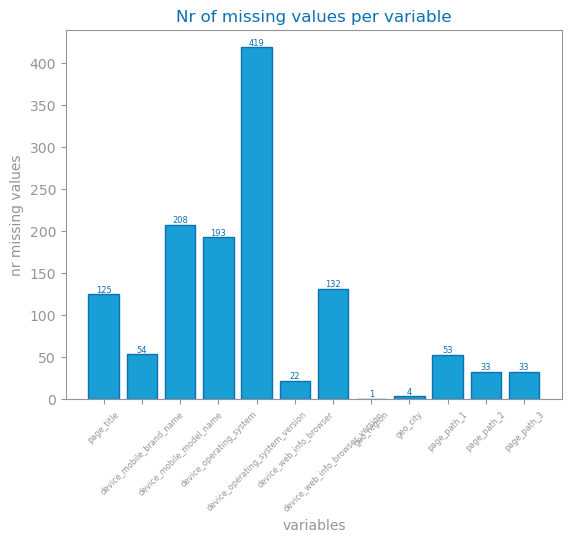

In [51]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

figure()
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
# savefig(f"{file_tag}_mv.png")
show()